Zero-Mean-Unit-Variance, first 4 sample: 
[[-0.6924 -0.5403]
 [-1.0523 -1.3452]
 [-0.2475 -1.0972]
 [ 1.1374  1.5503]]
----------------------------------------------------------------------------------------------------
Hyperparameter:
learning rate: 0.6   batch size: 32   number of epochs: 100
----------------------------------------------------------------------------------------------------
Accuracy for training set is:  0.975609756097561
Accuracy for validation set is:  0.975609756097561
----------------------------------------------------------------------------------------------------
confusion matrix for training set
[[200   5]
 [  5 200]]
confusion matrix for validation set
[[40  1]
 [ 1 40]]
Train Accuracy:  0.975609756097561
confusion matrix:
[[200   5]
 [  5 200]]
Train Accuracy:  0.975609756097561
confusion matrix:
[[40  1]
 [ 1 40]]


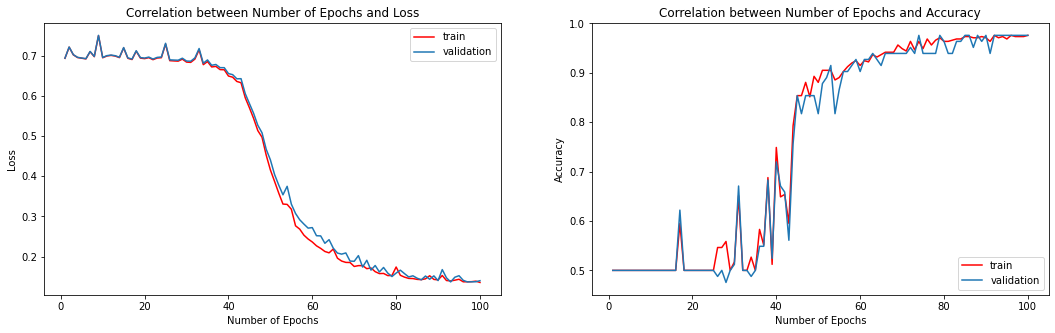

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

np.set_printoptions(precision=4, suppress=True, threshold=np.inf)


# feature normalization
def zero_mean_unit_variance(X):
    X_mean = X.mean(axis=0)
    X_std = X.std(axis=0)
    return (X - X_mean) / X_std


def activation(x):
    return sigmoid(x)


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def activation_derivative(x):
    return sigmoid_derivative(x)


def sigmoid_derivative(x):
    return sigmoid(x) * (1 - sigmoid(x))


def compute_loss(a, y):
    loss = binary_cross_entropy(a, y)
    return loss


def binary_cross_entropy(a, y):
    return -np.nan_to_num(np.log(a)*y + (1 - y)*np.log(1 - a)).sum() / y.shape[0]


def loss_derivative(a, y):
    delta = binary_cross_entropy_derivative(a, y)
    return delta


def binary_cross_entropy_derivative(a, y):
    return y / a - (1 - y) / (1 - a)


# initialize weight and bias for each neuron
def initialization(elements_per_layer):
    w = list()
    b = list()
    for i in range(0, elements_per_layer.shape[0] - 1):
        w.append(np.random.randn(elements_per_layer[i + 1], elements_per_layer[i]) / np.sqrt(elements_per_layer[i]))
        b.append(np.random.randn(elements_per_layer[i + 1], 1))
    return w, b


# organize the training data into batches
def make_batches(x_train, y_train, batch_size):
    # to shuffle the data, we need the whole data set first
    norm_data = np.column_stack((x_train, y_train))
    np.random.shuffle(norm_data)

    x_batches = list()
    y_batches = list()

    for i in range(1, norm_data.shape[0] // batch_size + 2):
        if i * batch_size > norm_data.shape[0]:
            row = norm_data.shape[0]
        else:
            row = i * batch_size
        x_batches.append(norm_data[(i - 1) * batch_size:row, 0:2])
        y_batches.append(norm_data[(i - 1) * batch_size:row, 2:3])
    return x_batches, y_batches


def forward_pass(x_batch, w, b, layers):
    a = x_batch
    zs = list()
    activations = list()
    zs.append(x_batch)
    activations.append(x_batch)
    for i in range(0, layers):
        z = a@w[i].T + b[i].T
        zs.append(z)
        a = activation(z)
        activations.append(a)
    return activations, zs


def backward_pass(activations, zs, layers, y_batch, w):
    delta_w = list()
    delta_b = list()
    # compute gradient for each single data
    for i in range(0, y_batch.shape[0]):
        y = y_batch[i]
        for j in range(layers, 0, -1):
            if j == layers:
                # output layer
                delta = activations[layers][i:i + 1, :] - y
            else:
                # hidden layer
                activ_deri = activation_derivative(zs[j][i:i + 1, :]).T
                delta = (w[j].T@delta)*activ_deri
            loss_w = delta@activations[j - 1][i:i+1, :]
            loss_b = delta
            if i == 0:
                delta_w.insert(0, loss_w)
                delta_b.insert(0, loss_b)
            else:
                delta_w[j - 1] = delta_w[j - 1] + loss_w
                delta_b[j - 1] = delta_b[j - 1] + loss_b
    return delta_w, delta_b


# batch-wise gradient descent to update w and b
def update_parameters(w, b, delta_w, delta_b, η, num_sample):
    # 4 lists: w, b, delta_w, delta_b
    for i in range(0, len(w)):
        # delta_w and delta_b: delta for all data samples in a batch
        # get the average as the final delta for the whole batch
        delta_w_avg = delta_w[i] / num_sample
        delta_b_avg = delta_b[i] / num_sample
        w[i] = w[i] - delta_w_avg * η
        b[i] = b[i] - delta_b_avg * η
    return w, b


def stopping_criteria(num_epochs, max_epochs):
    stop = False
    if num_epochs >= max_epochs:
        stop = True
    return stop


# using SGD to train the MLP
def train(x_train, y_train, η, batch_size, max_epochs, w, b, layers, x_vali, y_vali):
    num_epochs = 0
    acc_train_epochs = list()
    acc_vali_epochs = list()
    loss_train_epochs = list()
    loss_vali_epochs = list()
    y_hats = list()
    while not stopping_criteria(num_epochs, max_epochs):
        # get two lists: x_batches, y_batches
        x_batches, y_batches = make_batches(x_train, y_train, batch_size)
        for i in range(0, len(x_batches)):
            # for each batch
            x_batch = x_batches[i]
            y_batch = y_batches[i]

            # forward the batch through the network layers
            activations, zs = forward_pass(x_batch, w, b, layers)

            # compute the loss
            loss = list()
            loss.append(compute_loss(activations[layers], y_batch))

            # perform backward pass
            delta_w, delta_b = backward_pass(activations, zs, layers, y_batch, w)

            # update the weights of the network
            w, b = update_parameters(w, b, delta_w, delta_b, η, x_batch.shape[0])
        num_epochs = num_epochs + 1

        # loss - epoch
        y_train_hats, _ = forward_pass(x_train, w, b, layers)
        y_vali_hats, _ = forward_pass(x_vali, w, b, layers)
        if stopping_criteria(num_epochs, max_epochs):
            y_hats.append(y_train_hats[layers])
            y_hats.append(y_vali_hats[layers])
        loss_train_epochs.append(compute_loss(y_train_hats[layers], y_train))
        loss_vali_epochs.append(compute_loss(y_vali_hats[layers], y_vali))

        # accuracy - epoch
        acc_train_epochs.append(evaluation(w, b, x_train, y_train, layers))
        acc_vali_epochs.append(evaluation(w, b, x_vali, y_vali, layers))
    return w, b, acc_train_epochs, acc_vali_epochs, loss_train_epochs, loss_vali_epochs, y_hats


# accuracy of training set or validation set
def evaluation(w, b, X, Y, layers):
    activations, zs = forward_pass(X, w, b, layers)
    Y_hat = activations[layers]
    Y_hat = np.where(Y_hat >= 0.5, 1, Y_hat)
    Y_hat = np.where(Y_hat < 0.5, 0, Y_hat)
    count = 0
    for i in range(0, Y.shape[0]):
        if math.isclose(Y[i], Y_hat[i], rel_tol=1e-5):
            count = count + 1
    return count / Y.shape[0]


def confusion_matrix(y, y_hat):
    true_true = 0
    true_false = 0
    false_true = 0
    false_false = 0
    y_hat = np.where(y_hat >= 0.5, 1, y_hat)
    y_hat = np.where(y_hat < 0.5, 0, y_hat)
    for i in range(0, y.shape[0]):
        if y[i] == 1 and y_hat[i] == 1:
            true_true = true_true + 1
        if y[i] == 1 and y_hat[i] == 0:
            true_false = true_false + 1
        if y[i] == 0 and y_hat[i] == 1:
            false_true = false_true + 1
        if y[i] == 0 and y_hat[i] == 0:
            false_false = false_false + 1
    return np.array([[true_true, true_false], [false_true, false_false]])


if __name__ == '__main__':
    data_6_train = pd.read_csv('./data/train_data.csv')
    data_6_vali = pd.read_csv('./data/validate_data.csv')

    X_train_6 = data_6_train[['X_1', 'X_2']].values
    Y_train_6 = data_6_train[['y']].values

    X_vali_6 = data_6_vali[['X_1', 'X_2']].values
    Y_vali_6 = data_6_vali[['y']].values

    data_6_train0 = data_6_train[data_6_train['y'] == 0]
    data_6_train1 = data_6_train[data_6_train['y'] == 1]

    # plt.scatter(data_6_train0['X_1'], data_6_train0['X_2'], color="red", label="y = 0")
    # plt.scatter(data_6_train1['X_2'], data_6_train1['X_2'], label="y = 1")
    # plt.legend()
    # plt.show()

    # normalization
    x_train = zero_mean_unit_variance(X_train_6)
    y_train = Y_train_6

    x_vali = zero_mean_unit_variance(X_vali_6)
    y_vali = Y_vali_6

    print("Zero-Mean-Unit-Variance, first 4 sample: ")
    print(x_train[0:4])

    # Define the hyperparameters. Add any additional hyperparameters you might need
    η = 0.6  # learning rate
    batch_size = 32
    max_epochs = 100
    elements_per_layer = np.array([2, 10, 10, 1])
    layers = elements_per_layer.shape[0] - 1

    # initialization: get two list w and b for wx + b
    w, b = initialization(elements_per_layer)

    # training
    w, b, acc_train_epochs, acc_vali_epochs, loss_train_epochs, loss_vali_epochs, y_hats = train(x_train, y_train, η, batch_size, max_epochs, w, b, layers, x_vali, y_vali)

    print('-' * 100)
    print('Hyperparameter:\nlearning rate: {lr}   batch size: {bs}   number of epochs: {ep}'.format(lr=η, bs=batch_size, ep=max_epochs))

    # accuracy on training and validation set
    print('-' * 100)
    acc = evaluation(w, b, x_train, y_train, layers)
    print('Accuracy for training set is: ', acc)

    acc_1 = evaluation(w, b, x_vali, y_vali, layers)
    print('Accuracy for validation set is: ', acc_1)

    # confusion matrix
    print('-' * 100)
    cm_train = confusion_matrix(y_train, y_hats[0])
    cm_vali = confusion_matrix(y_vali, y_hats[1])
    print('confusion matrix for training set')
    print(cm_train)
    print('confusion matrix for validation set')
    print(cm_vali)

    print('Train Accuracy: ', acc)
    print('confusion matrix:')
    print(cm_train)

    print('Train Accuracy: ', acc_1)
    print('confusion matrix:')
    print(cm_vali)

    # plot
    at = np.array(acc_train_epochs)
    av = np.array(acc_vali_epochs)
    lt = np.array(loss_train_epochs)
    lv = np.array(loss_vali_epochs)
    epochs = np.array([i for i in range(1, max_epochs+1)])

    plt.figure(2, figsize=(18, 5))
    plt.subplot(1, 2, 1)
    plt.title("Correlation between Number of Epochs and Loss")
    plt.plot(epochs, lt, color="red", label="train")
    plt.plot(epochs, lv, label="validation")
    plt.legend(loc='upper right')
    plt.xlabel('Number of Epochs')
    plt.ylabel('Loss')

    plt.subplot(1, 2, 2)
    plt.title("Correlation between Number of Epochs and Accuracy")
    plt.plot(epochs, at, color="red", label="train")
    plt.plot(epochs, av, label="validation")
    plt.legend(loc='lower right')
    plt.xlabel('Number of Epochs')
    plt.ylabel('Accuracy')
    plt.show()


